In [1]:
import networkx as nx
from pykeen.pipeline import pipeline
from pykeen.datasets import Nations, get_dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from pykeen.models import predict


C:\Users\gianl\anaconda3\envs\MasterThesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pipeline_result = pipeline(
    dataset='Nations',
    model='TransE',
)
pipeline_result.save_to_directory('/nations_transe')


No random seed is specified. Setting to 73388055.
No cuda devices were available. The model runs on CPU
Training epochs on cpu: 100%|██████████| 5/5 [00:00<00:00,  6.75epoch/s, loss=1.38, prev_loss=1.39]
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
Evaluating on cpu: 100%|██████████| 201/201 [00:00<00:00, 3.42ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=14, num_relations=55, create_inverse_triples=False, num_triples=1592, path="C:\Users\gianl\anaconda3\envs\MasterThesis\Lib\site-packages\pykeen\datasets\nations\train.txt") to file:///C:/nations_transe/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///C:/nations_transe


<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

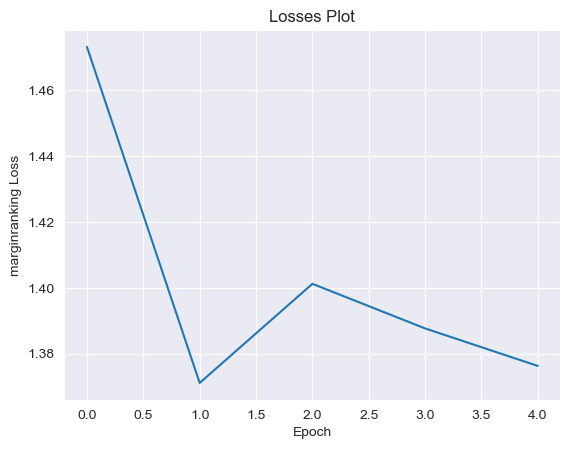

In [3]:
pipeline_result.plot_losses()

In [4]:
model = pipeline_result.model
# Predict tails
predicted_tails_df = predict.get_prediction_df(
    model=model, head_label="brazil", relation_label="intergovorgs", triples_factory=pipeline_result.training,
)
# Predict relations
predicted_relations_df = predict.get_prediction_df(
    model=model, head_label="brazil", tail_label="uk", triples_factory=pipeline_result.training,
)
# Predict heads
predicted_heads_df = predict.get_prediction_df(
    model=model, relation_label="conferences", tail_label="brazil", triples_factory=pipeline_result.training
)
predicted_tails_df

,tail_id,tail_label,score,in_training
0,0,brazil,-6.185877,False
7,7,israel,-9.974950,True
8,8,jordan,-10.209084,False
11,11,uk,-10.299041,True
13,13,ussr,-10.672518,False
9,9,netherlands,-10.676133,True
3,3,cuba,-10.888611,False
12,12,usa,-10.957547,True
10,10,poland,-10.985241,False
6,6,indonesia,-11.305741,True


In [5]:
# Score all triples (memory intensive)
predictions_df = predict.get_all_prediction_df(model, triples_factory=pipeline_result.training)

scoring: 100%|██████████| 770/770 [00:00<00:00, 1.75kbatch/s]


In [6]:
# Score top K triples (computationally expensive)
top_k_predictions_df = predict.get_all_prediction_df(model, k=150, triples_factory=pipeline_result.training)

scoring: 100%|██████████| 770/770 [00:00<00:00, 1.50kbatch/s]


In [7]:
# Score a given list of triples
score_df = predict.predict_triples_df(
    model=model,
    triples=[("brazil", "conferences", "uk"), ("brazil", "intergovorgs", "uk")],
    triples_factory=pipeline_result.training,
)
score_df

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
0,0,brazil,9,conferences,11,uk,-9.406466
1,0,brazil,20,intergovorgs,11,uk,-10.299041


In [8]:
from pykeen.evaluation import evaluate, ClassificationEvaluator

In [9]:
results = evaluate(model=model,mapped_triples=pipeline_result.training.mapped_triples,evaluator = ClassificationEvaluator(),mode=None,additional_filter_triples=[pipeline_result.training.mapped_triples])

INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
Evaluating on cpu:  68%|██████▊   | 1.09k/1.59k [00:00<00:00, 9.95ktriple/s]C:\Users\gianl\anaconda3\envs\MasterThesis\lib\site-packages\rexmex\metrics\classification.py:484: RuntimeWarning: invalid value encountered in power
  pthr = (fpr**0.5) / (fpr**0.5 + tpr**0.5)
C:\Users\gianl\anaconda3\envs\MasterThesis\lib\site-packages\rexmex\metrics\classification.py:547: RuntimeWarning: invalid value encountered in power
  fm = (ppv * tpr) ** 0.5
Evaluating on cpu: 100%|██████████| 1.59k/1.59k [00:00<00:00, 5.99ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.29s seconds


In [10]:
results.to_dict()

{'true_negative_rate': 10.607074737548828,
 'true_positive_rate': -9.857707977294922,
 'positive_predictive_value': 0.2550588548183441,
 'negative_predictive_value': 0.7453969120979309,
 'false_negative_rate': 10.857707977294922,
 'false_positive_rate': -9.607074737548828,
 'false_discovery_rate': 0.7449411749839783,
 'false_omission_rate': 0.25460314750671387,
 'positive_likelihood_ratio': 1.0260883569717407,
 'negative_likelihood_ratio': 1.023628830909729,
 'prevalence_threshold': nan,
 'threat_score': 0.3547079861164093,
 'fowlkes_mallows_index': nan,
 'informedness': -0.25063323974609375,
 'markedness': 0.0004557371139526367,
 'diagnostic_odds_ratio': 1.0024027824401855,
 'roc_auc_score': 0.4845444604072553,
 'accuracy_score': 0.6067892503536068,
 'balanced_accuracy_score': 0.4759933997170931,
 'f1_score': 0.21419597989949749,
 'average_precision_score': 0.226655623915164,
 'matthews_correlation_coefficient': -0.04801320056581377}

In [11]:
Nations().summarize()

Nations (create_inverse_triples=False)
Name        Entities    Relations      Triples
----------  ----------  -----------  ---------
Training    14          55                1592
Testing     14          55                 201
Validation  14          55                 199
Total       -           -                 1992
Head    Relation            tail
------  ------------------  ------
brazil  blockpositionindex  china
brazil  blockpositionindex  cuba
brazil  blockpositionindex  poland
brazil  blockpositionindex  ussr
brazil  booktranslations    uk



In [12]:
nations_dataset = get_dataset(dataset='nations')
nations_training = nations_dataset.training
triples = nations_training.mapped_triples
triples_list = triples.tolist() # head, relation type, tail
pairs = list(map(lambda x: [x[0],x[2]],triples_list))
pairs

INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///C:/Users/gianl/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///C:/Users/gianl/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///C:/Users/gianl/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///C:/Users/gianl/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation


[[0, 2],
 [0, 3],
 [0, 10],
 [0, 13],
 [0, 11],
 [0, 12],
 [0, 2],
 [0, 3],
 [0, 10],
 [0, 13],
 [0, 1],
 [0, 4],
 [0, 7],
 [0, 8],
 [0, 9],
 [0, 11],
 [0, 12],
 [0, 3],
 [0, 5],
 [0, 12],
 [0, 13],
 [0, 12],
 [0, 4],
 [0, 5],
 [0, 9],
 [0, 10],
 [0, 12],
 [0, 13],
 [0, 12],
 [0, 9],
 [0, 11],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 9],
 [0, 11],
 [0, 12],
 [0, 13],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 9],
 [0, 11],
 [0, 12],
 [0, 3],
 [0, 5],
 [0, 9],
 [0, 11],
 [0, 12],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 9],
 [0, 10],
 [0, 11],
 [0, 12],
 [0, 5],
 [0, 9],
 [0, 10],
 [0, 11],
 [0, 12],
 [0, 12],
 [0, 11],
 [0, 12],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 9],
 [0, 10],
 [0, 11],
 [0, 12],
 [0, 13],
 [0, 9],
 [0, 11],
 [0, 12],
 [0, 3],
 [0, 5],
 [0, 7],
 [0, 9],
 [0, 11],
 [0, 12],
 [0, 5],
 [0, 7],
 [0, 9],
 [0, 11],
 [0, 12],
 [0, 12],
 [0, 7],
 [0, 9],
 [0, 10],
 [0, 11],
 [0, 13],
 [0, 12],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 9],
 [0, 10],
 [0, 11],
 [0, 12],
 [0, 13],
 [0, 12],
 [0

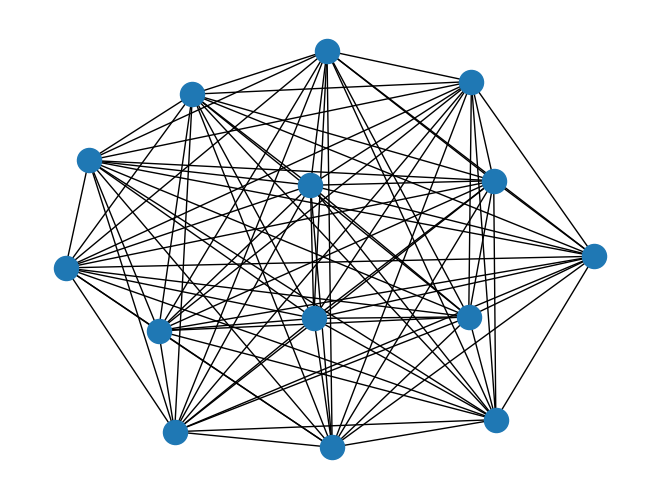

In [13]:
# Create a graph object
G = nx.Graph()

# Add the edges from the PyKEEN dataset
G.add_edges_from(pairs)

# Use NetworkX's built-in drawing function to visualize the graph
nx.draw(G)

# Import matplotlib library to show the graph
plt.show()


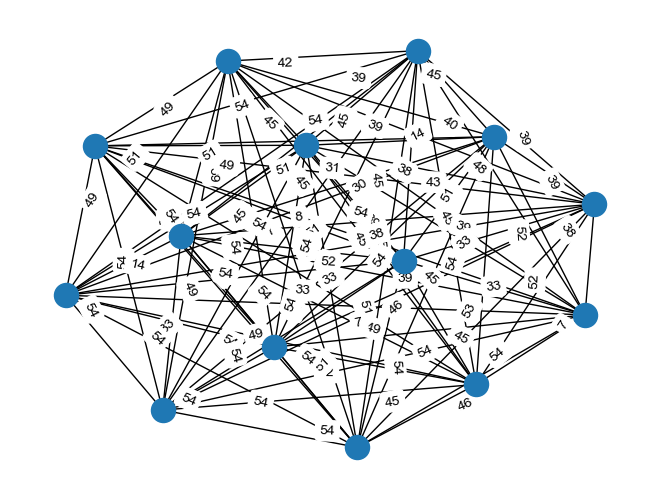

In [14]:
# Create a graph object
G = nx.Graph()

# Add the edges from the PyKEEN dataset
for triplet in triples_list:
    G.add_edge(triplet[0], triplet[2], label=triplet[1])

# Use NetworkX's built-in drawing function to visualize the graph
nx.draw(G)
pos = nx.spring_layout(G)

nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'label'))

# Import matplotlib library to show the graph
plt.show()


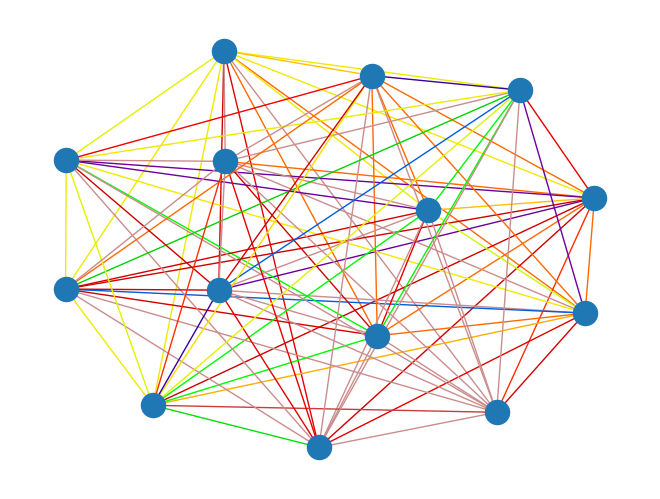

In [15]:
cmap = mpl.cm.nipy_spectral
norm = mpl.colors.Normalize(vmin=1, vmax=55)

# Create a graph object
G = nx.Graph()

# Add the edges from the PyKEEN dataset
for triplet in triples_list:
    G.add_edge(triplet[0], triplet[2], color=cmap(norm(triplet[1])))
    
colors = nx.get_edge_attributes(G,'color').values()

# Use NetworkX's built-in drawing function to visualize the graph
nx.draw(G,edge_color = colors)


# Import matplotlib library to show the graph
plt.show()


In [16]:
triples_factory = Nations().training
entity_ids = torch.as_tensor(triples_factory.entities_to_ids(["china", "egypt"]))
relation_ids = torch.as_tensor(triples_factory.relations_to_ids(["independence", "embassy"]))

In [17]:
relation_ids

tensor([19, 14])